<a href="https://colab.research.google.com/github/kithmini-wijesiri/De-Novo-Molecular-Generation/blob/main/Generating_molecules_with_GFlowNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# De Novo Generation

Goal: propose new molecules while optimizing their properties. This optimization is done "from scratch", **de novo**, rather than by searching through an existing list of compounds. here we develop algorithms that can modify or propose molecules while making sure that these molecules are "reasonable".

## Installing python libraries

**On Google Colab**

Start this first cell on colab to get things installed while reading the rest of the notebook. (If you get a message about `pydevd_plugins` you can safely ignore it)

**From scratch**

The following cell of `pip` will also install `torch==2.3.0+cu121`. If your local cuda version doesn't match, make sure to change that, and to change the `pyg.org/...` link on the second line to point to the same `torch` version. If you already have `torch` installed and would rather not change it, you can similarly edit the link to match your torch version.

In [ ]:
try:
  import torch
  assert torch.__version__.startswith('2.3') and 'cu121' in torch.__version__
except:
  print("We're probably not in collab and couldn't find the right torch.")
  !pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu121

!pip install medchem mol_ga safe-mol torch_geometric torch_sparse torch_scatter rdkit gitpython omegaconf wandb --find-links https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install --no-deps git+https://github.com/recursionpharma/gflownet.git@f106cde
# !pip install botorch gpytorch linear_operator jaxtyping pyro-ppl --no-deps

# Part 1: Setting up and exploring `medchem` and `graph-ga`

In [ ]:
import torch
import torch.nn as nn
import io, requests
from rdkit import Chem

class EGFRPredictor:
  def __init__(self):
    r = io.BytesIO(requests.get("https://storage.googleapis.com/emmanuel-data/models/egfr_linear.pt").content)
    state_dict = torch.load(r)
    self.linear = nn.Linear(2048, 1)
    self.linear.load_state_dict(state_dict)
  def predict(self, mols):
    if isinstance(mols[0], str):
      mols = [Chem.MolFromSmiles(i) for i in mols]
    fps = torch.tensor([Chem.RDKFingerprint(i) for i in mols]).float()
    with torch.no_grad():
      return self.linear(fps)[:, 0]

predictor = EGFRPredictor()

Let's instanciate some molecules to use as examples

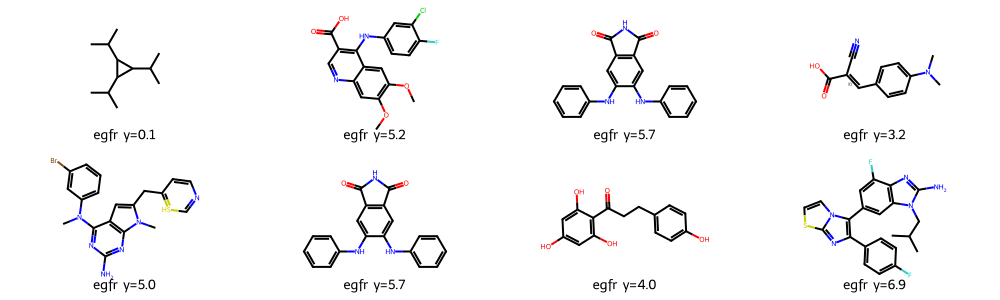

In [ ]:
import datamol as dm
some_mols = [Chem.MolFromSmiles(i) for i in
 ['CC(C)C1C(C(C)C)C1C(C)C',
  'C1(=C(OC)C=C2C(=C1)C(NC=3C=CC(=C(C3)Cl)F)=C(C=N2)C(=O)O)OC',
  'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1',
  'C(\\C(=O)O)(=C/C=1C=CC(=CC1)N(C)C)/C#N',
  'C=1C(Br)=CC=CC1N(C2=NC(N)=NC=3N(C(=CC23)CC4=SC=NC=C4)C)C',
  'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1',
  'C1=C(C=C(C(=C1O)C(CCC=2C=CC(=CC2)O)=O)O)O',
  'S1C=2N(C(C=3C=C4N(C(=NC4=C(F)C3)N)CC(C)C)=C(N2)C5=CC=C(F)C=C5)C=C1']
]
ys = predictor.predict(some_mols)
dm.to_image(some_mols, legends=[f'egfr y={i:.1f}' for i in ys], n_cols=4, mol_size=(250, 150))

The y values in the predictor.predict(some_mols) call represent the predicted scores for each molecule's binding affinity or activity toward the EGFR. These predictions come from the linear model (self.linear) that was trained using molecular fingerprints as input features. We'd like to produce molecules that strike the highest possible score.

Aside from producing molecules with high binding affinity, it would be good to also use our knowledge of chemistry to try and generate "reasonable molecules". Typically we want the molecule to be stable, to be synthesizable, to not be toxic, and to go through the body in a sensible way (often referred to with this combination of letters: (`ADME[T]`).

Predicting those properties is quite hard.
 So use simpler heuristics. Here we will recruit the help of the [`medchem`](https://github.com/datamol-io/medchem) library.

Here we try to augment our score predictor with some simple filtering. For example, we can use some pattern detectors to look for [PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds):

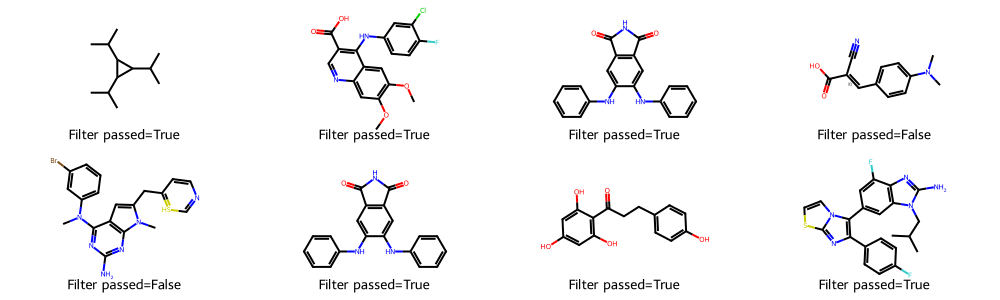

In [ ]:
import medchem as mc
accepted = mc.functional.alert_filter(some_mols, ['PAINS'])
legends = [f"Filter passed={o}" for o in accepted]
dm.to_image(some_mols, legends=legends, n_cols=4, mol_size=(250, 150))

Or see if the molecules pass [Lipinski's rule-of-five](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five):

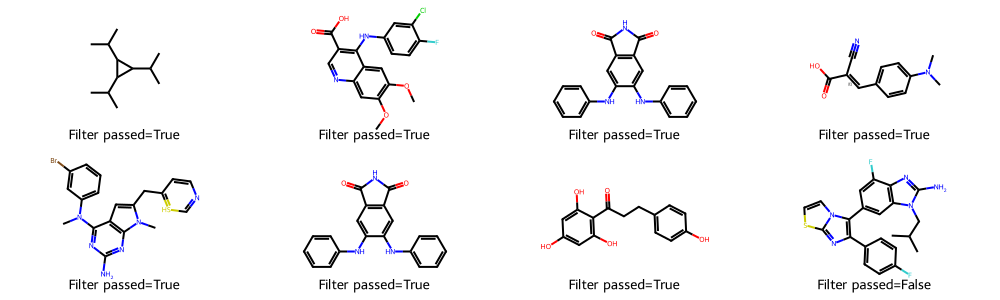

In [ ]:
accepted = [mc.rules.basic_rules.rule_of_five(i) for i in some_mols]
legends = [f"Filter passed={o}" for o in accepted]
dm.to_image(some_mols, legends=legends, n_cols=4, mol_size=(250, 150))

There's a whole set of "rules" and filters [implemented in medchem](https://medchem-docs.datamol.io/stable/tutorials/Basic_Concepts.html).


Now we use our predictor and some of these heuristics to create a score function.

In [ ]:
class EGFRScore:
  def __init__(self, predictor):
    self.predictor = predictor
  def score(self, mols):
    # TODO: incorporate more medchem heuristics
    ys = self.predictor.predict(mols)
    ro5 = 1 - torch.tensor([mc.rules.basic_rules.rule_of_five(i) for i in mols]).float()
    pains = 1 - torch.tensor(mc.functional.alert_filter(mols, ['PAINS'])).float()
    return ys / 2 ** (ro5 + pains)  # Divide the score by 2 every time a filter is unhappy

In [ ]:
scorer = EGFRScore(predictor)

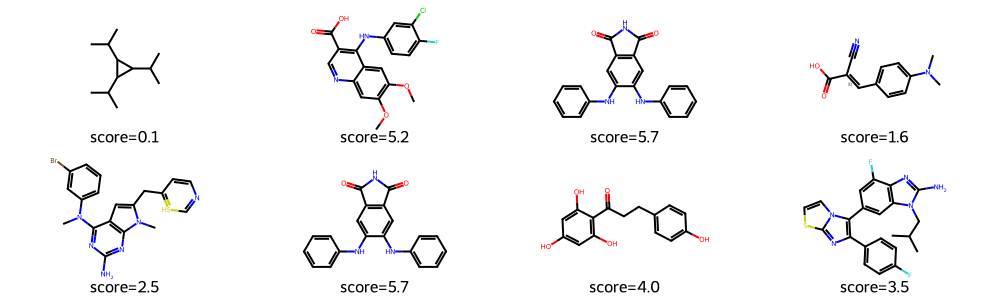

In [ ]:
scores = scorer.score(some_mols)
dm.to_image(some_mols, legends=[f'score={i:.1f}' for i in scores], n_cols=4, mol_size=(250, 150))

## Generate-and-filter

We now have a predictor that scores molecular candidates both on their expected binding affinity, and heuristic-based drug-likeness. Now we can generate new molecules that maximise these properties.

Approach 1: Generate new molecules "randomly" and filter them based on the scoring function. For this, we will use a graph-based genetic algorithm, [GraphGA](https://github.com/AustinT/mol_ga). This method does random edits on the molecular graph to mutate members of its population.

For example, here we mutate one of the above molecules (with no preoccupation for score) for just one step:

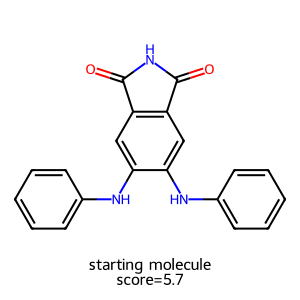

In [ ]:
starting_mol = 'C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1'
starting_score = scorer.score([Chem.MolFromSmiles(starting_mol)])[0]
dm.to_image(starting_mol, legends=[f'starting molecule\nscore={starting_score:.1f}'])

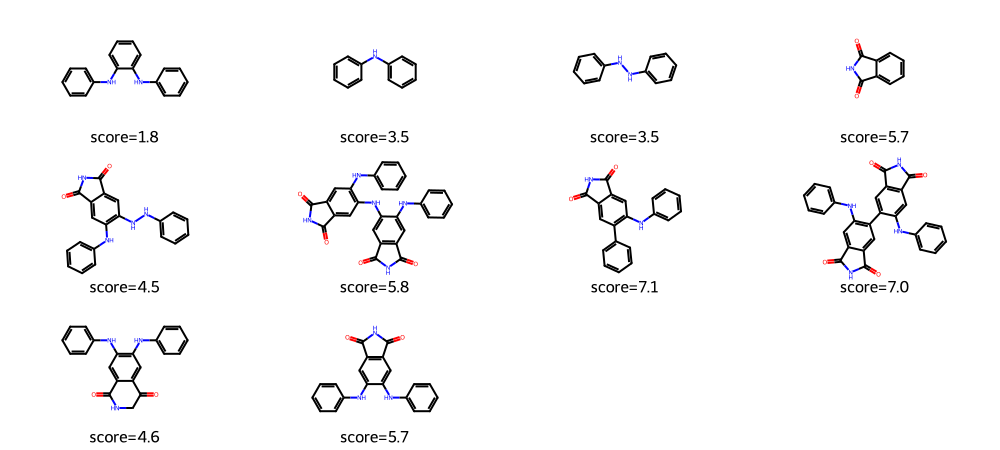

In [ ]:
from mol_ga import default_ga
f = lambda mols: [1 for i in mols]  # same score for all molecules (for unguided generation)
neighbors = default_ga(
    starting_population_smiles=[starting_mol],
    scoring_function=f,
    max_generations=1,
    offspring_size=11,
)

# Show generated molecules with our EGFP score
generated_mols = [m[1] for m in neighbors.population]
legends = [f'score={s:.1f}' for s in scorer.score(generated_mols)]
dm.to_image(generated_mols, n_cols=4, mol_size=(250, 150), legends=legends)

We created local variants of the molecule. This unguided generation could, by chance, lead to higher scored molecules than our starting candidate, but this is highly inefficient. A better approach is to repeat this local variation generation process over many generations. At each generation, we can filter for the best $N$ molecules to become the starting population of the next iteration. This is the approach followed by Genetic Algorithms, and it allows us to gradually start creating better and better molecules:

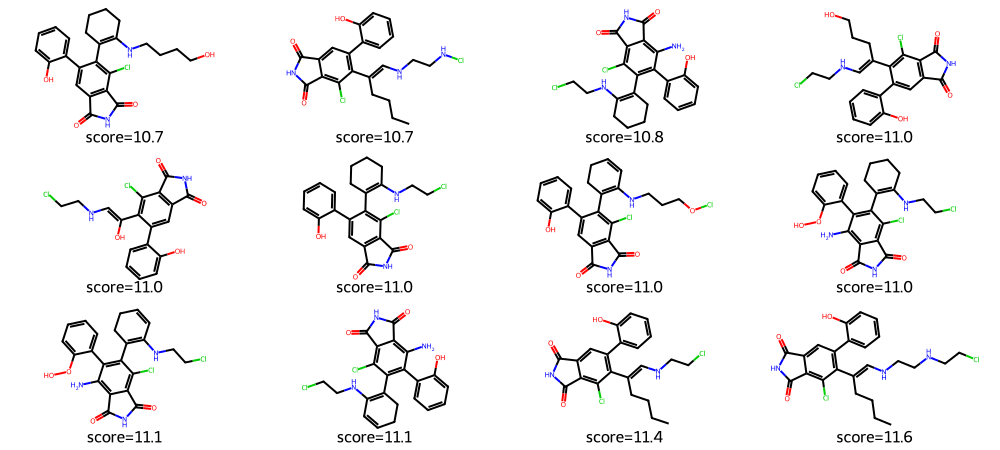

In [ ]:
import joblib
from mol_ga import default_ga

starting_smiles = ['C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O)C=CC1']

# Run GA with fast parallel generation
with joblib.Parallel(n_jobs=2) as parallel:
    ga_results = default_ga(
        starting_population_smiles=starting_smiles,
        scoring_function=scorer.score,
        max_generations=20,
        offspring_size=64,
        parallel=parallel,
    )

# Show the best molecules
top = sorted(ga_results.population)[-12:]
dm.to_image([i[1] for i in top], legends=[f'score={i[0]:.1f}' for i in top], n_cols=4, mol_size=(250, 150))

Here we generated molecules with much higher scores than we started with.

However, we notice that these molecules all look fairly similar to one another which is a known problem in MCMC-like approaches. In short, since we are exploring by local-search, traversing regions of the chemical space with lower score in order to get to a more promising starting point gets exponentially less likely the further these "good regions" are from one another.

# Part 2: Exploring `gflownet` for fragment-based molecular design


GFlowNets, or generative flow networks, are a class of energy-based models that work well on discrete combinatorial problems, like generating molecules. GFlowNets have built-in mechanisms for diversity, making them a more efficient way to more explore the chemical space.

## Fragment-based design

There is a large number of methods that can generate fragments. Here we went ahead and ran a variant of [BRICS](https://pubmed.ncbi.nlm.nih.gov/18792903/) on Chembl to obtain 50 common fragments.

The list below matches each fragment's SMILES string (e.g. `'c1cn[nH]c1'`) with the atoms to which the fragment can be attached to other fragments (e.g. `[0, 1, 3, 4]`).

In [ ]:
# Fragments
chembl_fragments = [
 ('Cl', [0]),
 ('c1ccccc1', [0, 1, 2, 3, 4, 5]),
 ('N', [0]),
 ('c1ccc2ncccc2c1', [0, 1, 2, 5, 6, 7, 9]),
 ('C#N', [0]),
 ('O', [0]),
 ('CC', [0, 1]),
 ('NC=O', [0, 1]),
 ('C=C', [0, 1]),
 ('C', [0]),
 ('CNC', [1]),
 ('c1ccc2scnc2c1', [0, 1, 2, 5, 8]),
 ('c1ccc2[nH]cnc2c1', [0, 1, 2, 4, 5, 8]),
 ('c1cn[nH]c1', [0, 1, 3, 4]),
 ('O=[NH+][O-]', [1]),
 ('C1COCCN1', [0, 1, 3, 4, 5]),
 ('c1cncnc1', [0, 1, 3, 5]),
 ('S', [0]),
 ('c1nnc[nH]1', [0, 3, 4]),
 ('C1CC1', [0, 1, 2]),
 ('CNC=O', [0, 2]),
 ('F', [0]),
 ('C=O', [0]),
 ('O=C1c2ccccc2C2NCCN12', [8, 9]),
 ('FC(F)F', [1]),
 ('C1CNCCN1', [0, 1, 2, 3, 4, 5]),
 ('c1ccc2c(c1)CN1CCN=C21', [0, 1, 2, 5, 6, 9]),
 ('c1nncs1', [0, 3]),
 ('c1ccc2ncncc2c1', [0, 1, 2, 5, 7, 9]),
 ('Br', [0]),
 ('c1ccsc1', [0, 1, 2, 4]),
 ('O=S=O', [1]),
 ('CCC', [1]),
 ('c1cnc2c(c1)CCO2', [0, 1, 5, 7]),
 ('c1ccncc1', [0, 1, 2, 4, 5]),
 ('C1CCNCC1', [0, 1, 2, 3, 4, 5]),
 ('O=C1CCCN1', [2, 3, 4, 5]),
 ('C=C(C#N)C#N', [0]),
 ('O=C1[CH]NC[CH]N1', [2, 3, 4, 5]),
 ('O=CO', [1]),
 ('[CH]NC=O', [0, 2]),
 ('c1ccc2[nH]ccc2c1', [0, 1, 2, 4, 5, 6, 8]),
 ('CO', [0, 1]),
 ('O=C1[CH]CCN1', [2, 3, 4, 5]),
 ('[CH]C', [0]),
 ('[CH]O', [0]),
 ('CN', [0, 1]),
 ('O=C1NC[CH][CH]Oc2ccccc21', [2, 4, 5, 8, 10]),
 ('I', [0]),
 ('c1cscn1', [0, 1, 3])]

Let's visualise our fragment library.

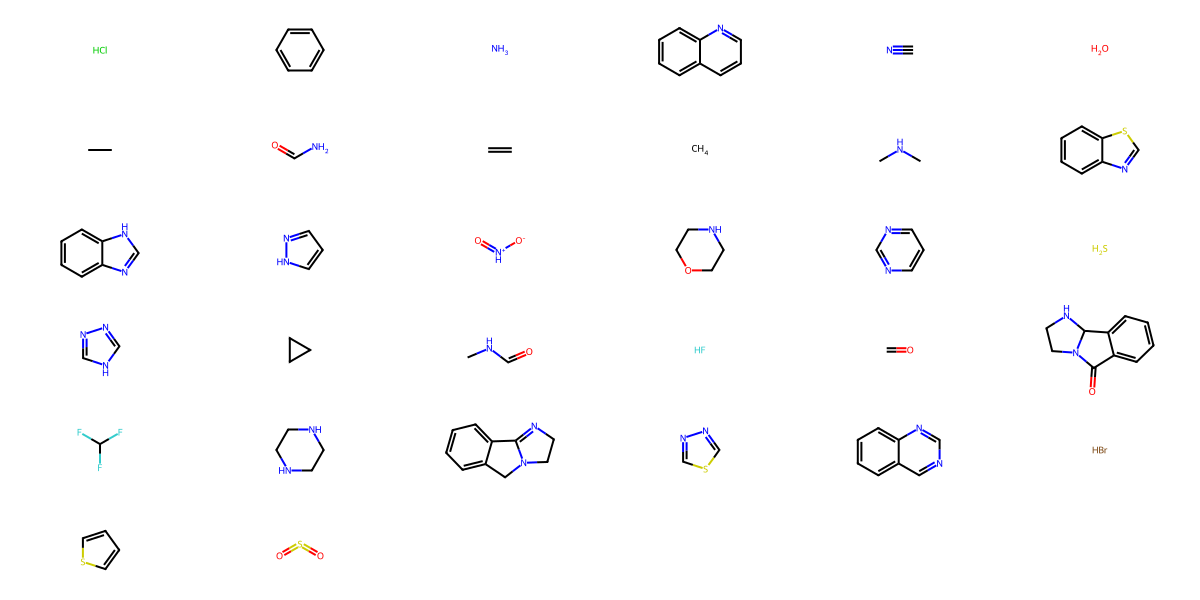

In [ ]:
dm.to_image([i[0] for i in chembl_fragments], n_cols=6, mol_size=(200, 100))

Now that we have a fragment library, let's import the things we need to start building!

In [ ]:
import torch
import gflownet
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.algo.trajectory_balance import TrajectoryBalance

Initialize the basic blocks we need and simply use default values for most options:
- the `Config` is where hyperparameters are set (e.g. number of GNN layers, log directory, and so on)
- the `GraphBuildingEnv` is an high-level, agnostic, graph-handling environment (it does not care what the graphs represent, could be a causal graph, a molecular graph, etc.)
- the `-Context` class defines an "implementation" of the environment, this is where we specify what the graphs represent (in this case graphs of molecular fragments)
- the model, is our main model; for GFlowNet it can output $P_F$, $F(s)$ or even $\log Z$
- the `algo`, `TrajectoryBalance`, defines how to (a) sample a model (b) construct a training batch and (c) train a model

In [ ]:
torch.manual_seed(1)

# Let's also set a few config values
cfg = Config()
cfg.model.num_layers = 4
cfg.model.num_emb = 64  # we don't need a big model

# And instantiate the rest
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext(fragments=chembl_fragments, max_frags=5)  # setting the maximum number of nodes in our graph to 5
model = GraphTransformerGFN(ctx, cfg)
algo = TrajectoryBalance(env, ctx, cfg)

Let's load CUDA if we can:

In [ ]:
if torch.cuda.is_available():
    from gflownet.utils.misc import set_main_process_device
    model.cuda()
    dev = torch.device('cuda')
    set_main_process_device(dev)
else:
    dev = torch.device('cpu')
dev

device(type='cuda')

Now, let's sample our model to see what comes out.

In [ ]:
trajs = algo.create_training_data_from_own_samples(model, 4)  # Sample 4 trajectories

A trajectory contains a few things of interest:

In [ ]:
list(trajs[0].keys())

['traj',
 'reward_pred',
 'is_valid',
 'is_sink',
 'fwd_logprob',
 'bck_logprob',
 'bck_logprobs',
 'result',
 'bck_a']

We can take a look at the 'traj' key, which contains the sequence of states and actions forming the trajectory:

In [ ]:
for state, action in trajs[0]['traj']:
    print(state, action)

<[], [], []> <GraphActionType.AddNode, 0, 36>
<[0], [], [36]> <GraphActionType.AddNode, 0, 11>
<[0, 1], [(0, 1)], [36, 11]> <GraphActionType.AddNode, 0, 43>
<[0, 1, 2], [(0, 1), (0, 2)], [36, 11, 43]> <GraphActionType.AddNode, 2, 49>
<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [36, 11, 43, 49]> <GraphActionType.AddNode, 2, 9>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 2, 3, dst_attach, 1>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 1, dst_attach, 0>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 2, 3, src_attach, 2>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 2, dst_attach, 1>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36, 11, 43, 49, 9]> <GraphActionType.SetEdgeAttr, 0, 1, src_attach, 2>
<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (2, 4)], [36

Notice here that, since we produce a fragment graph in the form of a junction tree, the only actions the agent is allowed to perform are `AddNode` (attach a new fragment node to an existing node), and `SetEdgeAttr` (in the fragment case, set which atom in the fragment molecule is used in the bond). It can also end the trajectory by using the `Stop` action.

Let's see what's being produced (i.e. the 'result'). We can do so by asking the Context class to map our abstract `Graph`s back to whatever object type the context deals with (in this case, rdkit molecules).

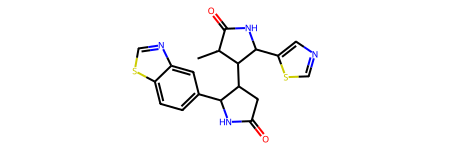

In [ ]:
mol = ctx.graph_to_obj(trajs[0]['result'])
mol

To train GFlowNet to produce *good* molecules, we're going to need a reward function.

In this library, reward functions are defined in a `Task`. A task defines not only the reward function, but also is able to handle things like distributions of conditional information. For simplicy, let's reuse an existing task (the task the GFlowNets were developed for, `SEHTask`, which rewards molecules with a high binding affinity to the sEH protein) and subclass it to make our own:

In [ ]:
#botorch is used for multi-objective optimization and hypervolume calculations
!pip install botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.9/631.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gflownet 0.1.14 requires torch-cluster==1.6.3, which is not installed.
gflownet 0.1.14 requires torch==2.1.2, but you have torch 2.3.0+cu121 which is incompatible.
gflownet 0.1.14 requires torch-geometric==2.4.0, but you have torch-geometric 2.5.3 which is in

In [ ]:
from gflownet.tasks.seh_frag import SEHTask

class EGFRTask(SEHTask):
  def compute_obj_properties(self, mols):
    is_valid = torch.ones(len(mols)).bool()  # We could make some molecules "invalid"
    return scorer.score(mols).clip(1e-4).reshape((-1, 1)), is_valid  # Clip to make sure the score is positive

task = EGFRTask(cfg)

We can now ask the task to compute rewards; note that we first have to convert the graphs into objects (molecules here).

(Note: we also have to specify the `beta` conditional. In `SEHTask` the model is trained to sample molecules with a probability proportional to $\hat{R} = R(x)^\beta$. In our gigantic state space, many molecules will have a low reward while only a rare few will have higher rewards. This inverse temperature parameter $\beta$ allows the model to be "greedier" and better focus on the high reward molecules.)

In [ ]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(4)}, obj_props)

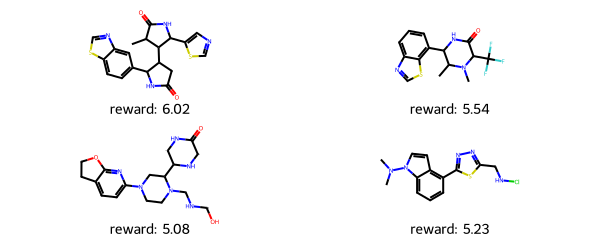

In [ ]:
dm.to_image(objs, n_cols=2, mol_size=(300, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards])

We have molecules, we have rewards, we can now train the model.

For this we have to construct a training batch from the trajectories. `TrajectoryBalance` will then compute the loss based on it (and based on the `Config` we gave it).

In [ ]:
batch = algo.construct_batch(trajs, cond_info=None, log_rewards=log_rewards).to(dev)
loss, info = algo.compute_batch_losses(model, batch)
loss

tensor(464.8176, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
opt = torch.optim.Adam(model.parameters(), 3e-4)

In [ ]:
loss.backward()
opt.step()
opt.zero_grad()

Train our model with a larger $\beta$

In [ ]:
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 48
losses = []
avg_rewards = []
for i in tqdm(range(100)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, n=64)

        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        obj_props, _ = task.compute_obj_properties(objs)
        log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs)) * beta}, obj_props)

    batch = algo.construct_batch(trajs, cond_info=None, log_rewards=log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(loss.item())
    avg_rewards.append((log_rewards / beta).exp().mean().item())

  0%|          | 0/100 [00:00<?, ?it/s]

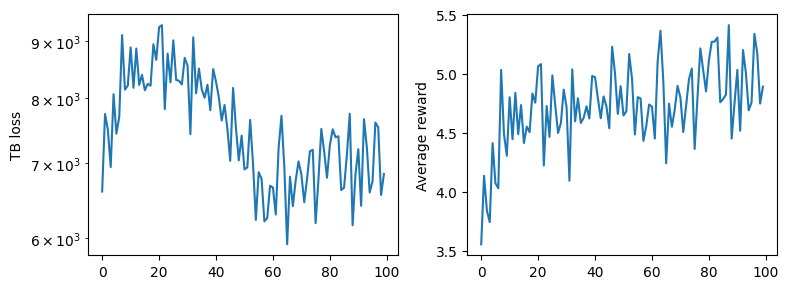

In [ ]:
import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 2, figsize=(8,3))
ax[0].plot(losses)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot(avg_rewards)
ax[1].set_ylabel('Average reward')
pp.tight_layout()

Average reward is going up, and the loss is going down (it's normal for it to not immediately go down in GFlowNets).

 The generated molecules look diverse.

In [ ]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)

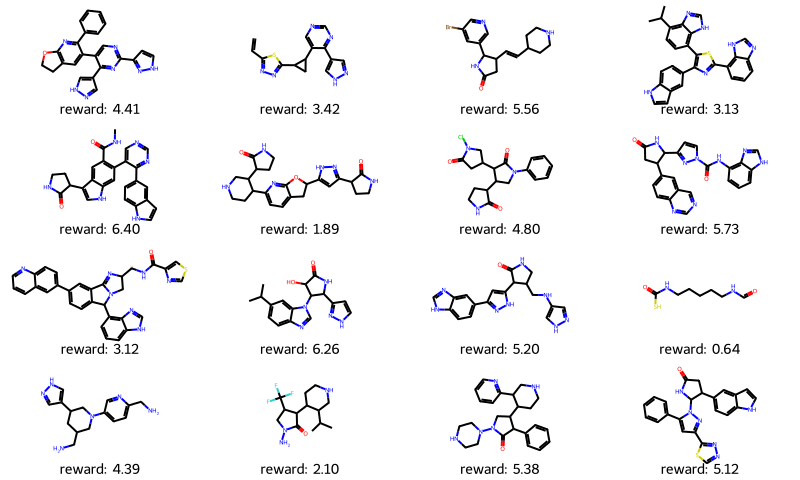

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(objs[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

## Atom-graph design

 Instead of using fragments, we can use `gflownet` to directly generate the atom graph.

In [ ]:
from typing import Dict, List, Tuple
import torch
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor

# Config stuff
from gflownet.config import Config, init_empty
# This is our per-atom-generation environment
from gflownet.envs.mol_building_env import MolBuildingEnvContext

# This is the basic GFN trainer that we'll reuse for our purposes
from gflownet.online_trainer import StandardOnlineTrainer

class AtomEGFRTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        # Here we choose some specific parameters, in particular, we don't want
        # molecules of more than 25 heavy atoms, so we set
        cfg.algo.max_nodes = 25

        # This creates a lagged sampling model, see https://arxiv.org/abs/2310.19685
        cfg.algo.sampling_tau = 0.9

        # It is possible that our GFN generates impossible molecules. This will be
        # their logreward:
        cfg.algo.illegal_action_logreward = -100
        # Disable random actions
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0

    def setup_task(self):
        # The task we created above
        self.task = EGFRTask(self.cfg)

    def setup_env_context(self):
        # The per-atom generation context
        self.ctx = MolBuildingEnvContext(
            ["C", "F", "S", "O", "N", "Cl"],
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0,  # disable random-walk features
            max_nodes=self.cfg.algo.max_nodes,  # Limit the number of atoms
            num_cond_dim=self.task.num_cond_dim,
        )


We can now run the setup like this:

In [ ]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./log_dir_atom"
config.overwrite_existing_exp = True
config.device = dev
config.num_training_steps = 10
config.num_workers = 2
config.num_validation_gen_steps = 1

trial = AtomEGFRTrainer(config, print_config=False)
trial.run()

08/09/2024 20:31:35 - INFO - logger - Starting training


INFO:logger:Starting training
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


08/09/2024 20:31:52 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:2067.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.08 loss:2067.76 n_loss:0.00 tb_loss:2067.76 batch_entropy:70.37 traj_lens:21.27 grad_norm:1793.41 grad_norm_clip:83.71 sampled_reward_avg:1.51 train_time:0.38 time_spent:16.88


INFO:logger:iteration 1 : offline_loss:0.00 online_loss:2067.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.08 loss:2067.76 n_loss:0.00 tb_loss:2067.76 batch_entropy:70.37 traj_lens:21.27 grad_norm:1793.41 grad_norm_clip:83.71 sampled_reward_avg:1.51 train_time:0.38 time_spent:16.88


08/09/2024 20:31:52 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:1762.56 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.06 loss:1762.56 n_loss:0.00 tb_loss:1762.56 batch_entropy:56.43 traj_lens:17.17 grad_norm:8543.07 grad_norm_clip:90.18 sampled_reward_avg:1.43 train_time:0.26 time_spent:0.29


INFO:logger:iteration 2 : offline_loss:0.00 online_loss:1762.56 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.06 loss:1762.56 n_loss:0.00 tb_loss:1762.56 batch_entropy:56.43 traj_lens:17.17 grad_norm:8543.07 grad_norm_clip:90.18 sampled_reward_avg:1.43 train_time:0.26 time_spent:0.29


08/09/2024 20:32:14 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:2357.22 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.04 loss:2357.22 n_loss:0.00 tb_loss:2357.22 batch_entropy:71.73 traj_lens:20.94 grad_norm:2290.07 grad_norm_clip:84.03 sampled_reward_avg:1.63 train_time:0.33 time_spent:21.76


INFO:logger:iteration 3 : offline_loss:0.00 online_loss:2357.22 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.04 loss:2357.22 n_loss:0.00 tb_loss:2357.22 batch_entropy:71.73 traj_lens:20.94 grad_norm:2290.07 grad_norm_clip:84.03 sampled_reward_avg:1.63 train_time:0.33 time_spent:21.76


08/09/2024 20:32:15 - INFO - logger - iteration 4 : offline_loss:0.00 online_loss:2411.68 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.01 loss:2411.68 n_loss:0.00 tb_loss:2411.68 batch_entropy:76.06 traj_lens:22.55 grad_norm:4728.24 grad_norm_clip:87.75 sampled_reward_avg:1.83 train_time:0.47 time_spent:0.50


INFO:logger:iteration 4 : offline_loss:0.00 online_loss:2411.68 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.01 loss:2411.68 n_loss:0.00 tb_loss:2411.68 batch_entropy:76.06 traj_lens:22.55 grad_norm:4728.24 grad_norm_clip:87.75 sampled_reward_avg:1.83 train_time:0.47 time_spent:0.50


08/09/2024 20:32:37 - INFO - logger - iteration 5 : offline_loss:0.00 online_loss:2548.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.00 loss:2548.05 n_loss:0.00 tb_loss:2548.05 batch_entropy:83.35 traj_lens:24.59 grad_norm:2853.84 grad_norm_clip:85.56 sampled_reward_avg:1.84 train_time:0.36 time_spent:22.57


INFO:logger:iteration 5 : offline_loss:0.00 online_loss:2548.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.00 loss:2548.05 n_loss:0.00 tb_loss:2548.05 batch_entropy:83.35 traj_lens:24.59 grad_norm:2853.84 grad_norm_clip:85.56 sampled_reward_avg:1.84 train_time:0.36 time_spent:22.57


08/09/2024 20:32:41 - INFO - logger - iteration 6 : offline_loss:0.00 online_loss:2582.41 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:2582.41 n_loss:0.00 tb_loss:2582.41 batch_entropy:105.79 traj_lens:30.31 grad_norm:1578.82 grad_norm_clip:82.05 sampled_reward_avg:1.79 train_time:0.41 time_spent:4.17


INFO:logger:iteration 6 : offline_loss:0.00 online_loss:2582.41 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.02 loss:2582.41 n_loss:0.00 tb_loss:2582.41 batch_entropy:105.79 traj_lens:30.31 grad_norm:1578.82 grad_norm_clip:82.05 sampled_reward_avg:1.79 train_time:0.41 time_spent:4.17


08/09/2024 20:33:06 - INFO - logger - iteration 7 : offline_loss:0.00 online_loss:2890.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:2890.69 n_loss:0.00 tb_loss:2890.69 batch_entropy:101.77 traj_lens:28.38 grad_norm:2620.93 grad_norm_clip:85.92 sampled_reward_avg:2.14 train_time:0.54 time_spent:24.35


INFO:logger:iteration 7 : offline_loss:0.00 online_loss:2890.69 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.04 loss:2890.69 n_loss:0.00 tb_loss:2890.69 batch_entropy:101.77 traj_lens:28.38 grad_norm:2620.93 grad_norm_clip:85.92 sampled_reward_avg:2.14 train_time:0.54 time_spent:24.35


08/09/2024 20:33:13 - INFO - logger - iteration 8 : offline_loss:0.00 online_loss:2903.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2903.63 n_loss:0.00 tb_loss:2903.63 batch_entropy:103.43 traj_lens:29.75 grad_norm:3469.80 grad_norm_clip:87.40 sampled_reward_avg:2.04 train_time:0.38 time_spent:7.47


INFO:logger:iteration 8 : offline_loss:0.00 online_loss:2903.63 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2903.63 n_loss:0.00 tb_loss:2903.63 batch_entropy:103.43 traj_lens:29.75 grad_norm:3469.80 grad_norm_clip:87.40 sampled_reward_avg:2.04 train_time:0.38 time_spent:7.47


08/09/2024 20:33:32 - INFO - logger - iteration 9 : offline_loss:0.00 online_loss:2234.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2234.73 n_loss:0.00 tb_loss:2234.73 batch_entropy:88.45 traj_lens:26.11 grad_norm:1823.07 grad_norm_clip:83.36 sampled_reward_avg:1.58 train_time:0.37 time_spent:18.46


INFO:logger:iteration 9 : offline_loss:0.00 online_loss:2234.73 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.08 loss:2234.73 n_loss:0.00 tb_loss:2234.73 batch_entropy:88.45 traj_lens:26.11 grad_norm:1823.07 grad_norm_clip:83.36 sampled_reward_avg:1.58 train_time:0.37 time_spent:18.46


08/09/2024 20:33:39 - INFO - logger - iteration 10 : offline_loss:0.00 online_loss:2704.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.11 loss:2704.43 n_loss:0.00 tb_loss:2704.43 batch_entropy:105.87 traj_lens:30.42 grad_norm:3017.54 grad_norm_clip:86.55 sampled_reward_avg:2.26 train_time:0.45 time_spent:7.29


INFO:logger:iteration 10 : offline_loss:0.00 online_loss:2704.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:0.11 loss:2704.43 n_loss:0.00 tb_loss:2704.43 batch_entropy:105.87 traj_lens:30.42 grad_norm:3017.54 grad_norm_clip:86.55 sampled_reward_avg:2.26 train_time:0.45 time_spent:7.29


In [ ]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 16, torch.ones((16, trial.ctx.num_cond_dim)))

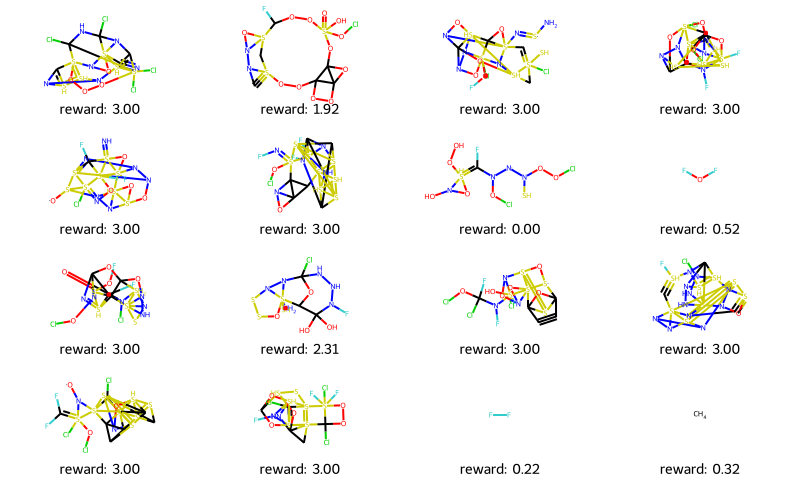

In [ ]:
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
MolsToGridImage(objs, molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

These molecules look so much worse than GraphGA's. GraphGA encodes lots of chemical priors in its mutation steps, this allows the method to produce "good looking" molecules without too much effort. As it is, the task and GFlowNet model do not encode such priors in any ways, and so the model is rewarded for producing "nonsense". This is a fairly hard challenge within atom-based design.

Because we've used `gflownet`'s `Trainer`s to run this, the results are logged for us:

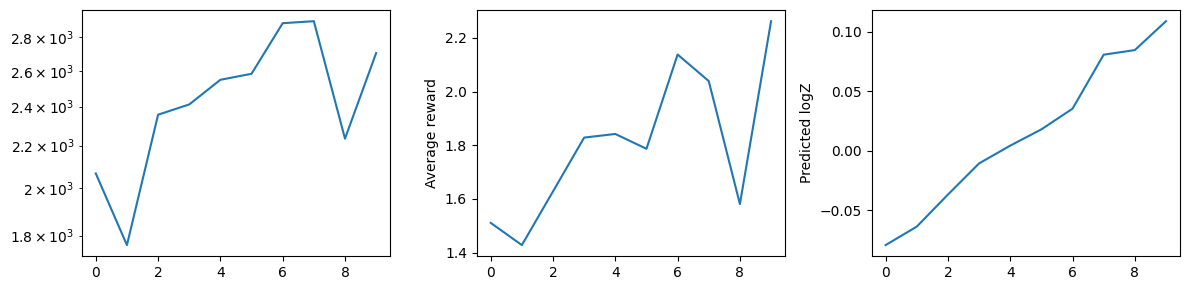

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = 'log_dir_atom'
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

In [ ]:
import importlib
import gflownet.utils.sqlite_log as sqll
importlib.reload(sqll)
results = sqll.read_all_results('./log_dir_atom/train/')
results

,smi,r,fr_0,ci_beta
0,[SH]#CCl,0.508368,0.508368,17.787626
1,NC(Cl)(C(O)O)N(Cl)n1[nH][nH]1,1.175714,1.175714,13.636193
2,ClOCl,0.014405,0.014405,23.190222
3,NS[SH](N(Cl)OCl)n1[nH][nH]1,3.288233,3.288232,23.028465
4,N[SH]1CC1(NOF)OCl,1.480816,1.480816,19.487047
...,...,...,...,...
635,FN=S1#S2(Cl)N3S1=S1(Cl)=C=NN4OS256(F)C27OC(O[S...,3.004864,3.004864,18.057117
636,ClCl,0.252518,0.252518,8.313057
637,C,0.316643,0.316643,27.607363
638,NN1OOC23NS4(S)C2(CCl)S2(F)(F)(O3)N(Cl)C(Cl)(Cl...,3.004864,3.004864,23.401894


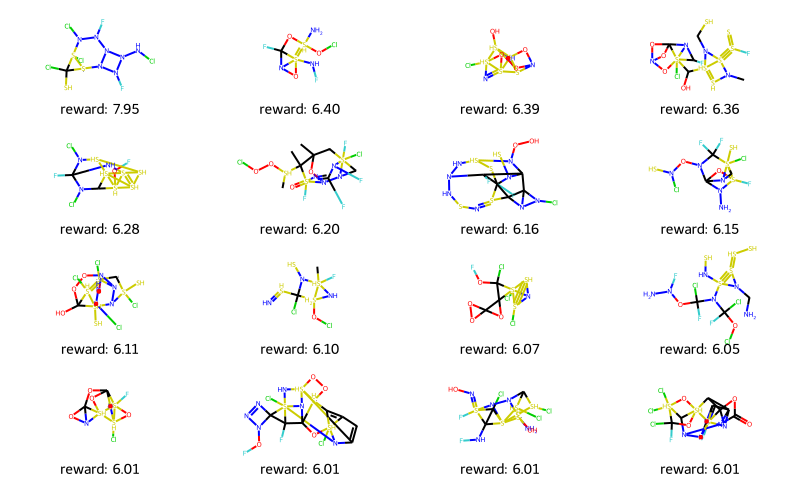

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
top_k = np.argsort(results['r'])[-16:][::-1]
rewards = results['r'][top_k]
mols = [Chem.MolFromSmiles(i) for i in results['smi'][top_k]]
MolsToGridImage(mols[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards])

# Part 3: Exploring `safe-gpt` for generating molecules from language modeling



In [ ]:
# Import the stuff we need
import torch
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from transformers import AutoTokenizer, AutoModel
import safe as sf
import traceback
import datamol as dm

##  SAFE encoding demo

SAFE strings are a special SMILES encoding that also *are* SMILES string. This is done by converting the SMILES string into its graphical representation, running a molecular fragmentation algorithm, and then recombining the SMILES-representation for each fragment into a single string. This yields our SAFE-encoding, a valid SMILES string that can still be fed into any rdkit function, but that is much better suited for language models.

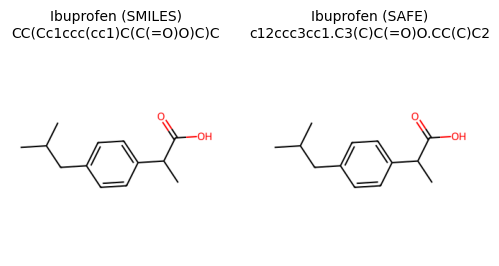

In [ ]:
ibuprofen = "CC(Cc1ccc(cc1)C(C(=O)O)C)C"
ibuprofen_sf = sf.encode(ibuprofen)  # c12ccc3cc1.C3(C)C(=O)O.CC(C)C2

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(Draw.MolToImage(Chem.MolFromSmiles(ibuprofen)))
axes[0].set_title(f"Ibuprofen (SMILES)\n{ibuprofen}", fontsize=10)
axes[0].axis("Off")
axes[1].imshow(Draw.MolToImage(Chem.MolFromSmiles(ibuprofen_sf)))
axes[1].set_title(f"Ibuprofen (SAFE)\n{ibuprofen_sf}", fontsize=10)
axes[1].axis("Off")
plt.show()

One of the first advantages is out-of-the-box data-augmentation. The fragments composing the SAFE-encoding can be recombined in any order without altering the nature of the molecule. This means that we can generate a lot of different SAFE-encodings for the same molecule, and use them as different training examples for a language model.

In [ ]:
ibuprofen = "CC(Cc1ccc(cc1)C(C(=O)O)C)C"
ibuprofen_sfs = sorted(list(set([sf.encode(ibuprofen, randomize=True) for _ in range(300)])))

celecoxib = "Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1"
celecoxib_sfs = list(set([sf.encode(celecoxib, randomize=True) for _ in range(300)]))

print(f"Number of unique SAFE encodings for ibuprofen ({len(ibuprofen_sfs[0].split('.'))} fragments): {len(ibuprofen_sfs)}")
print(f"Number of unique SAFE encodings for celecoxib ({len(celecoxib_sfs[0].split('.'))} fragments): {len(celecoxib_sfs)}")

Number of unique SAFE encodings for ibuprofen (3 fragments): 6
Number of unique SAFE encodings for celecoxib (4 fragments): 24


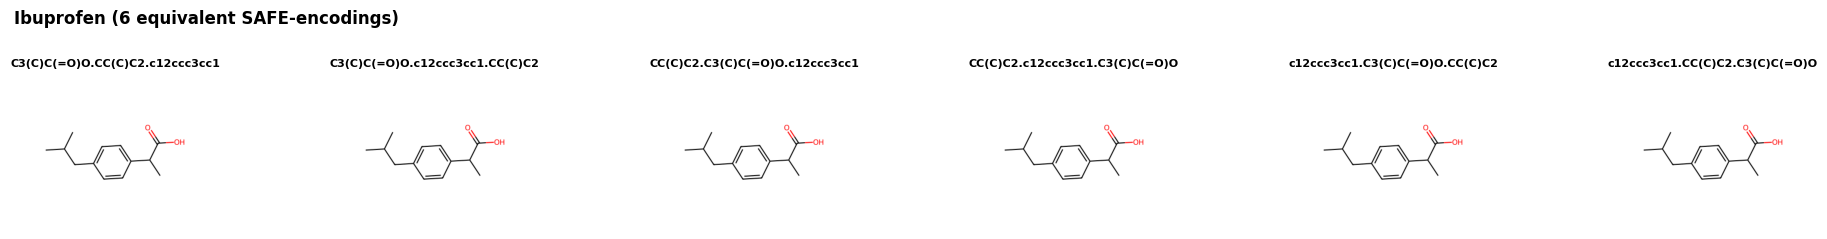

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(20, 2))
fig.text(0.05, 1.1, f"Ibuprofen ({len(ibuprofen_sfs)} equivalent SAFE-encodings)", ha="left", fontsize=12, fontweight="bold")
for i, safe in enumerate(ibuprofen_sfs):
    axes[i].imshow(Draw.MolToImage(Chem.MolFromSmiles(safe)))
    axes[i].axis("Off")
    axes[i].set_title(f"{safe}", fontsize=8, fontweight="bold")

fig.tight_layout()
fig.show()

SAFE fragments are molecules themselves, however, they are not guaranteed to be valid molecules. By using the decoder, we can fix fragments with un-fulfilled attachment points.

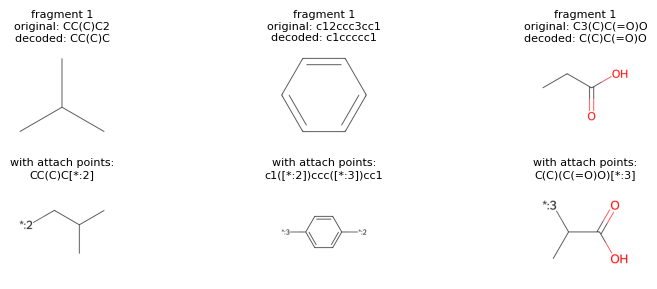

In [ ]:
frags = ibuprofen_sfs[3].split('.')

fig, axes = plt.subplots(2, len(frags), figsize=(3 * len(frags), 3))
for i, show_attach_points in enumerate([False, True]):
    for j, frag in enumerate(frags):
        axes[i,j].imshow(Draw.MolToImage(Chem.MolFromSmiles(sf.decode(frag, remove_dummies=not(show_attach_points)))))
        axes[i,j].axis("Off")
        if show_attach_points:
            axes[i,j].set_title(f"with attach points:\n{sf.decode(frag, remove_dummies=not(show_attach_points))}", fontsize=8)
        else:
            axes[i,j].set_title(f"fragment {i+1}\noriginal: {frag}\ndecoded: {sf.decode(frag)}", fontsize=8)

fig.tight_layout()
fig.show()

## Scaffold decoration

Now that we know what SAFE encodings are, we can leverage them to perform scaffold decoration.

Let's start by loading a pre-trained SAFE-GPT model:

In [ ]:
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)


We will use this scaffold:

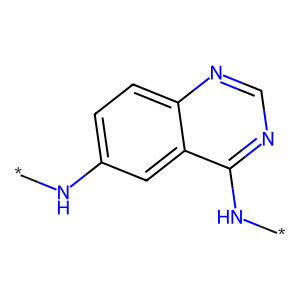

In [ ]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"
Draw.MolToImage(Chem.MolFromSmiles(scaffold))

The attachment points denoted by a `*` above will be used as anchoring point for new motifs to be attached. This can be performed out-of-the-box:

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
2024-09-08 20:38:37.785 | INFO     | safe.samp

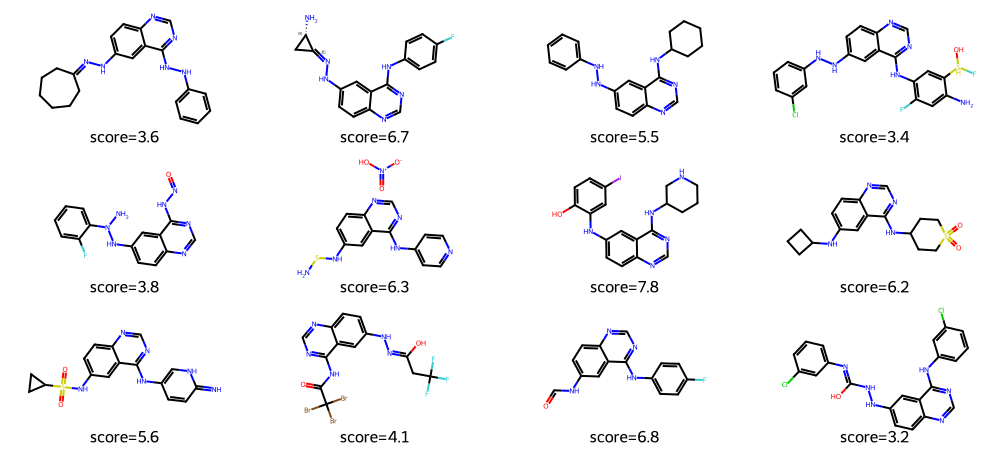

In [ ]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)
generated_mols = [dm.to_mol(x) for x in generated_smiles]
scores = scorer.score([Chem.MolFromSmiles(smile) for smile in generated_smiles])
legends = [f"score={score:.1f}" for score in scores]
dm.to_image(generated_mols[:12], legends=legends[:12], n_cols=4, mol_size=(250, 150))
# dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)